In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train = train.take(np.random.permutation(len(train)))

In [5]:
train.shape

(42000, 785)

In [6]:
train_size = 40000

num_labels = 10

def reformat(data, labels=None):
    data = data.reshape((-1,28,28,1)).astype(np.float32)
    try:
        labels = labels.astype(np.float32)
        labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
        return data, labels
    except:
        return data
    
    
train_data = train.iloc[:train_size,1:].as_matrix()
train_labels = train.iloc[:train_size,0].as_matrix()

valid_data = train.iloc[train_size:,1:].as_matrix()
valid_labels = train.iloc[train_size:,0].as_matrix()

train_data, train_labels = reformat(train_data, train_labels)
valid_data, valid_labels = reformat(valid_data, valid_labels)

#test_data = test.as_matrix()
#test_data = reformat(test_data)

del train
del test

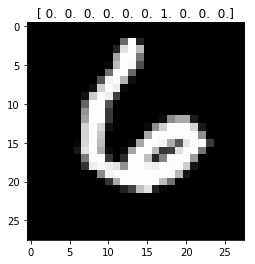

In [7]:
index = 100

train_data.shape
plt.title(train_labels[index])
plt.imshow(train_data[index].reshape((28,28)), cmap='gray')

In [8]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [10]:
batch_size = 128
image_size = 28
num_channels = 1
keep_prob = 0.8
filter_size = 5
channel_depths1 = 32
channel_depths2 = 64
num_hidden = 1024

graph = tf.Graph()
with graph.as_default():
    tf_train_data = tf.placeholder(dtype=np.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(dtype=np.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_data)
    #tf_test_data = tf.constant(test_data)

    w1 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, num_channels, channel_depths1]))
    b1 = tf.Variable(tf.truncated_normal(shape=[channel_depths1]))
    w2 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, channel_depths1, channel_depths2]))
    b2 = tf.Variable(tf.truncated_normal(shape=[channel_depths2]))

    w3 = tf.Variable(tf.truncated_normal(shape=[image_size*image_size//16 * channel_depths2, num_hidden]))
    b3 = tf.Variable(tf.truncated_normal(shape=[num_hidden]))

    w4 = tf.Variable(tf.truncated_normal(shape=[num_hidden, num_labels]))
    b4 = tf.Variable(tf.truncated_normal(shape=[num_labels]))


    def model(data, keep_prob=1.0):
        # first conv layer
        conv = tf.nn.conv2d(data, w1, strides=[1,1,1,1], padding='SAME')
        hidden = tf.nn.relu(conv + b1)
        hidden = tf.nn.avg_pool(hidden, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        hidden = tf.nn.dropout(hidden, keep_prob)

        # second conv layer
        conv = tf.nn.conv2d(hidden, w2, strides=[1,1,1,1], padding='SAME')
        hidden = tf.nn.relu(conv + b2)
        hidden = tf.nn.avg_pool(hidden, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        hidden = tf.nn.dropout(hidden, keep_prob)

        # flat the tensor
        shape = hidden.get_shape().as_list()
        hidden = tf.reshape(hidden, shape=[shape[0], -1])

        hidden = tf.nn.relu(tf.matmul(hidden, w3) + b3)
        hidden = tf.nn.dropout(hidden, keep_prob)
        return tf.matmul(hidden, w4) + b4

    logits = model(tf_train_data, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimization
    global_step = tf.Variable(0)
    learning_rate = 1e-4
    decay_steps = 1e+3
    decay_rate = 0.975
    learning_rate = tf.train.exponential_decay(learning_rate=learning_rate, 
                                               global_step=global_step,
                                               decay_steps=decay_steps,
                                               decay_rate=decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)


    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_data))
    #test_prediction = tf.nn.softmax(model(tf_test_data))

num_steps = 20000+1

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step + 1) * batch_size % train_labels.shape[0]
        batch_train_data = train_data[offset - batch_size:offset, :, :, :]
        batch_train_labels = train_labels[offset - batch_size:offset]

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_train_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_train_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_data:batch_train_data, tf_train_labels: batch_train_labels}
        _, l, predictions =sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if step % 500 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_train_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))


Minibatch loss at step 0: 5684422.500000
Minibatch accuracy: 12.5%
Validation accuracy: 12.2%
Minibatch loss at step 500: 899133.375000
Minibatch accuracy: 60.9%
Validation accuracy: 81.9%
Minibatch loss at step 1000: 467014.875000
Minibatch accuracy: 67.2%
Validation accuracy: 88.7%
Minibatch loss at step 1500: 217927.125000
Minibatch accuracy: 80.5%
Validation accuracy: 90.9%
Minibatch loss at step 2000: 254951.968750
Minibatch accuracy: 78.1%
Validation accuracy: 92.1%
Minibatch loss at step 2500: 123595.062500
Minibatch accuracy: 89.1%
Validation accuracy: 93.3%
Minibatch loss at step 3000: 93186.625000
Minibatch accuracy: 86.7%
Validation accuracy: 93.6%
Minibatch loss at step 3500: 128774.484375
Minibatch accuracy: 85.2%
Validation accuracy: 94.0%
Minibatch loss at step 4000: 67391.078125
Minibatch accuracy: 89.1%
Validation accuracy: 94.2%
Minibatch loss at step 4500: 76454.367188
Minibatch accuracy: 85.2%
Validation accuracy: 94.7%
Minibatch loss at step 5000: 59299.140625
Mini